# Step 1: Motion Correction

One of the biggest sources of variance in the fMRI timeseries is head motion. Unfortunately, motion in the scanner is inevitable as it is would unrealistic to expect all subjects to remain perfectly still for the duration of the experimental task. In cases where motion is particularly bad, it can cause such issues that the data cannot be used. Even in cases where the motion seems slight, changes in head position of as little as 2-3mm can corrupt the data. Motion is therefore a serious issue for the quality of our fMRI data. Although best to minimise movement at source, we must recognise that there will always be *some* head motion and must therefore be aware of what we can and cannot do to try and fix it.

## Problems With Motion

There are two main issues resulting from head motion. The first is that motion will cause individual voxels to suddenly contain data from a different part of the brain. The second is that motion can disrupt the recording of the signal by the scanner. Both these issues can be further compounded by motion that occurs more during certain conditions of the experimental task. In these case, the motion is *correlated* with the task, creating a serious confound in the data.

### Corruption of the Time Series

One of the main issue with motion is that the time series at an individual voxel is no longer a continuous measure of a specific point in the brain. Instead, the time series measures *several* points in the brain over time. Where this is particularly problematic is at tissue boundaries. For instance, motion may causes a voxel to contain signal from both *inside* and *outside* the head, or from both *inside* and *outside* the ventricles. In these cases, the change in tissue type will cause a sudden shift in signal intensity that may be misconstrued as true brain activity. This is shown in {numref}`mot-spikes-fig`, where 20 volumes in the middle of a functional series have been artificially shifted to the right and then back again. Without any form of correction, the sudden change of intensity in the highlighted voxel would likely be identified as true brain activation by the statistical analysis.

```{figure} images/mot-spikes.png
---
width: 600px
name: mot-spikes-fig
---
Illustration of how sudden changes in signal intensity can occur after head motion.
```

One saving grace of this form of motion is that it is often visible as activations that trace the border between tissue types. As such, any activation pattern that sits along the edge of the brain, or along the edge of internal structures, should be treated with extreme caution. An example is shown in {numref}`mot-edge-fig`.

```{figure} images/mot-edge.png
---
width: 500px
name: mot-edge-fig
---
Illustration of how motion artefacts can appear along the edges of the brain.
```

### Corruption of the Signal Measurement

A more insidious effect of motion is that it can impact the signal measured by the scanner. When the subject's head moves, protons from a neighbouring slice with a different excitation move into the voxel. This disrupts the magnetic gradients and alters the signal that will be measured. This is exacerbated when using an inter-leaved acquisition sequence, as the excitation differences between neighbouring slices will be greater. Importantly, these *spin-history* effects persist for several volumes, even if those volumes are not subject to motion themselves. Unfortunately, such effects are not a part of standard spatail motion correction techniques. Although spin-history correction has been proposed (e.g. [Friston et al, 1996](https://pubmed.ncbi.nlm.nih.gov/8699946/)), such methods are not in common use. In part, this is due to the complexity and poor understanding of the influence of spin-history on the BOLD signal. Instead, any residual effects of motion after pre-processing are usually accommodated during the statistical modelling. In extreme cases, spin-history effects will be visible as *striping* in the image, as shown in {numref}`spin-hist-fig`. Here, the top row shows an interleaved sequence and the bottom row shows a sequential sequence. The left column is a scan without motion and the right is a scan with motion.

```{figure} images/spin-history.gif
---
width: 500px
name: spin-hist-fig
---
Spin history effects in both an interleaved (*top*) and sequential (*bottom*) sequence. Images on the *right* contain motion, whereas images on the *left* contain no motion.
```

### Motion Correlated With the Task

Motion presents a particularly difficult problem when it occurs more in some conditions of the experimental task than others. For instance, consider a task with different difficulty conditions. It is plausible that frustration during the harder condition may cause subjects to move more, compared to the easier condition. If this happens, there will be greater movement-related intensity changes during the difficult condition. Unfortunately, such changes will be inseparable from intensity changes related to true brain activity. As such, any attempt to correct for the motion effects will likely reduce or remove the true brain activity. In this situation, motion becomes an inescapable confound and the scans cannot be used.

## Motion Correction Theory

Now that we have discussed the problems that head motion can cause, we can turn to motion correction techniques. Typically, spatial motion correction is performed as the first pre-processing step. This involves spatially transforming all the functional volumes so that are in alignment with one another. In principle, this will alleviate issues with the time series containing data from multiple brain regions, but it will not fix spin-history effects nor issues of task-correlated motion. In SPM, this form of motion correction is known as *realignment* and is illustrated in {numref}`realign-poldrack-fig` from [Poldrack, Mumford and Nichols (2011)](https://www.librarysearch.manchester.ac.uk/permalink/44MAN_INST/bofker/alma992975905221601631).

```{figure} images/realign-poldrack.png
---
width: 800px
name: realign-poldrack-fig
---
Illustration of motion correction.
```

At its most basic, spatial motion correction is an image registration problem. A single fMRI volume is chosen to act as the *reference* image and all the other volumes are then transformed to match. As such, you can think of motion correction as a series of registration steps, where the reference stays the same and the source is changed each time to a different fMRI volume. From this perspective, there is nothing unique about the mechanics of motion correction. The main focus of most motion correction algorithms is *speed*, given that hundreds of volumes need to be aligned in a reasonable amount of time. As such, most motion correction algorithms use *least-squares* as the cost function. In addition, motion correction only uses 6 parameters where the results of each previous alignment can be used as the starting point for the next alignment. Because motions are likely to be small, the optimisation algorithm is therefore always close to the optimal solution for each iteration and will converge very quickly. As such, we can think of motion correction as a highly-tuned and specific version of image registration.

### Motion Parameters

The registration parameters associated with each volume are one of the main outputs of motion correction. As we know, registration involves estimating a matrix $\mathbf{T}$ that is used to transform the *source* to match the *target*. For motion correction, there will be a $\mathbf{T}$ matrix for each volume. Each of these $\mathbf{T}_{t}$ matrices $(t=1,\dots,T)$ will contain the translations and rotations needed to best match volume $t$ to the reference volume. The parameters of these $\mathbf{T}_{t}$ matrices are then useful for indicating how much the subject moved during the scan. For instance, extracting and plotting the $x$-translations from each $\mathbf{T}$ matrix allows us to see how much the subject deviated from the target volume along the $x$-axis over time. An example of these forms of plots is shown below.

```{figure} images/mot-params.png
---
width: 800px
name: mot-params-fig
---
Example of the plots of motion parameters produced after motion correction.
```

### Resampling the fMRI Data

Once all the $\mathbf{T}_{t}$ matrices have been estimated, it would be typical to turn these world-space transformations into voxel-space transformations, effectively *applying* the motion correction to the data. Resampling at this stage is particularly important for slice-timing correction, which is our next pre-processing step. However, it is not always advisable to resample the data at this stage, as will be discussed further at the end of this lesson. In terms of the interpolation itself, higher-order B-spline methods are generally preferred, as evidence suggests that linear methods can introduce greater errors ([Ostuni et al., 1997](https://pubmed.ncbi.nlm.nih.gov/9294580/)). In principle, we could choose the highest-order interpolation available to us, but the gains in accuracy are likely going to be undone once we perform spatial smoothing as a final pre-processing step. As such, SPM defaults to 4th-degree B-spline interpolation as a reasonable compromise.

### How Much Motion is Too Much?

Considering the fact that motion is an unavoidable part of fMRI data, but is also potentially very damaging, how much motion should we allow before deciding a scan is too corrupted to use? This seems like an obvious question, but is actually very difficult to answer. Generally, volume-to-volume motion is more damaging than steady and slow motion, meaning that it is motion *spikes* that are most concerning. According to [Poldrack, Mumford and Nichols (2011)](https://www.librarysearch.manchester.ac.uk/permalink/44MAN_INST/bofker/alma992975905221601631), a sudden shift of more than $\frac{1}{2}$ a voxel should be cause for concern. For instance, if the voxels were 3mm isotropic then a spike of > 1.5mm in the $x$, $y$ or $z$ planes would be a concern. This is similar for rotations, where we can calculate the angle for a distance of 1.5mm using the formula for the *arc length* of a circle

$$
\theta = d\frac{180}{\pi r}
$$

where $d$ is the distance and $r$ is the radius. If we consider the head a circle, we can use an approximate radius of 50mm (Power et al., 2012). For 3mm isotropic voxels, this gives

$$
1.72 = 1.5 \times \frac{180}{\pi \times 50}
$$

such that any sudden rotation greater than 1.72$^{\circ}$ would be cause for concern. However, excluding an entire scan on the basis of a single large spike would seem unwise. As such, we need to consider not only the magnitude of the motion, but also the *extent* of motion through the fMRI series. A couple of spikes would suggest the data is recoverable, whereas a scan that is littered with motion spikes will almost certainly be a lost cause. As an example, the plot in {numref}`trans-spikes-fig` shows a couple of concerning spikes in the $z$-translation trace, but this would not be enough to suggest discarding the scan. However, if similar spikes were seen across the whole series, we would be concerned about the quality of the data.

```{figure} images/trans-spikes.png
---
width: 800px
name: trans-spikes-fig
---
Example of motion parameters containing large spikes. In this example, the spikes are not numerous enough to suggest discarding the scan.
```

## Motion Correction in SPM

Now that we have discussed the theory of motion correction, we can examine how to perform this step using SPM.

### Using the Graphical Batch System

The video below will demonstrate how to perform motion correction using the SPM graphical interface. Note that the default approach in SPM is a *two-pass* procedure, where the images are initially aligned to the first volume. A mean image is then created and a second pass is performed to align the volumes with the mean. The final $\mathbf{T}_{t}$ matrices therefore represent a combination of the transformations needed for both steps. The idea is that registration can be more finely tuned using this second pass, although, realistically, it will not make a huge difference. Importantly, we need to save this mean image for use in a later pre-processing step.

<div style="max-width: 1280px"><div style="position: relative; padding-bottom: 56.25%; height: 0; overflow: hidden;"><iframe src="https://livemanchesterac.sharepoint.com/sites/UOM-FBMH-MSc-NCCN/_layouts/15/embed.aspx?UniqueId=27a69ee8-454c-4fe5-a640-e172328d949f&embed=%7B%22hvm%22%3Atrue%2C%22ust%22%3Atrue%7D&referrer=StreamWebApp&referrerScenario=EmbedDialog.Create" width="1280" height="720" frameborder="0" scrolling="no" allowfullscreen title="3.Motion-Correction.mov" style="border:none; position: absolute; top: 0; left: 0; right: 0; bottom: 0; height: 100%; max-width: 100%;"></iframe></div></div>

### Using MATLAB Code

Beyond the graphical interface, it is also possible to perform motion correction in code using the `spm_realign` and `spm_reslice` functions. For example, the code below shows how to replicate the functionality of the `Realign: Estimate & Reslice` module from the video.

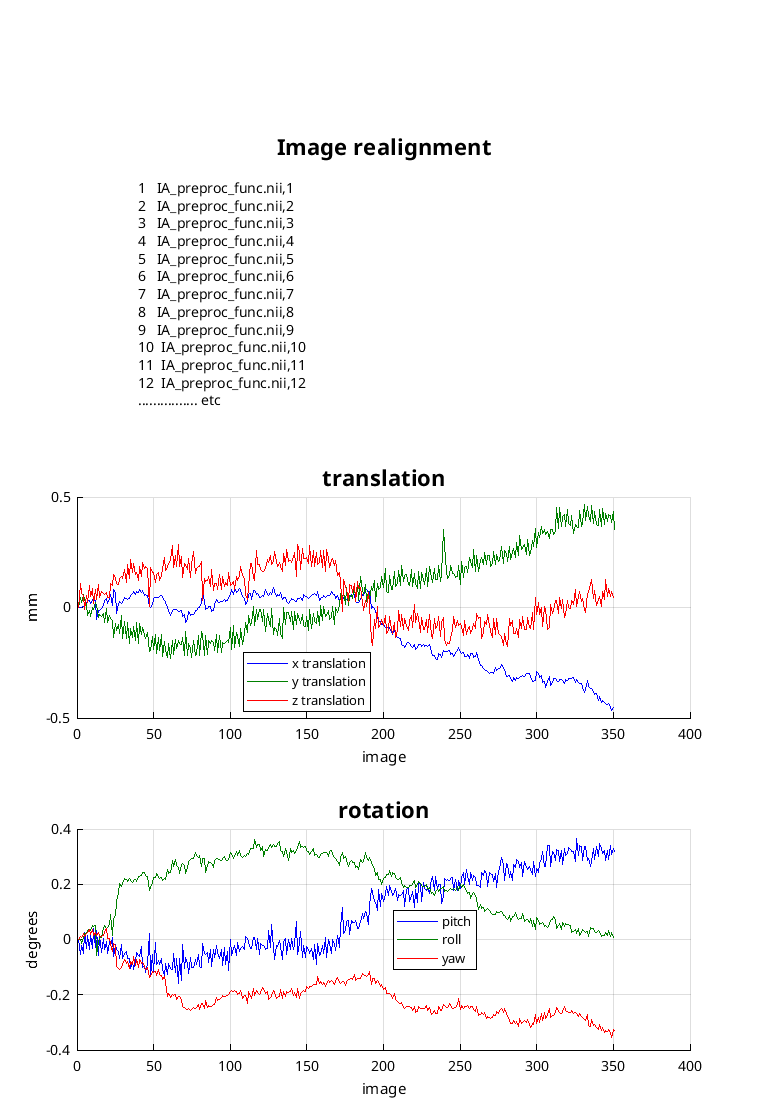


SPM12: spm_realign (v7141)                         13:47:51 - 01/11/2023
Printing 'Graphics' figure to:
  /home/martyn/Downloads/spm_2023Nov01.ps
Completed                               :          13:48:04 - 01/11/2023

SPM12: spm_reslice (v7141)                         13:48:05 - 01/11/2023
Completed                               :          13:48:13 - 01/11/2023


In [5]:
% Launch SPM
spm('defaults','FMRI');
spm_figure('GetWin','Graphics');                  % Open graphics window for plots

% Motion correction (estimate)
func      = spm_vol('IA_preproc_func.nii');
eopts     = spm_get_defaults('realign.estimate'); % Default options struct
eopts.rtm = 1;                                    % Set to 0 for 1-pass correction

spm_realign(func,eopts);                          

% Motion correction (resample)                     
mcfunc       = spm_vol('IA_preproc_func.nii');     
ropts        = spm_get_defaults('realign.write'); % Default options struct  
ropts.interp = 4;                                 % 4th-degree B-spline
ropts.which  = [2 1];                             % [2 1] = resample all volumes (2) and create mean (1)

spm_reslice(mcfunc,ropts);